Time Series Analysis
- Sales trends over time for each item
- forecasting:
    - Built arima models for each individual item using monthly sales data.
    - Forecasted future sales for the next 6 months.
    - Visualized both historical and predicted values using Plotly charts.


CF:
- Created a user-item review matrix (customers × clothing items).
- Used cosine similarity to compute item-item similarity based on review patterns.
- Built a tool to recommend items similar to any given product.
    - Hybrid Bundling (Co-purchase + Similarity):
        - Constructed a co-purchase matrix to see which items are bought together.
        - Combined this with cosine similarity scores to create a hybrid bundle ranking.
        - Generated top 3 bundle suggestions for every item.


In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
retail_df = pd.read_csv("retail_sales.csv")

# Clean and preprocess based on new columns
retail_df['date'] = pd.to_datetime(retail_df['date'])
retail_df['review'] = retail_df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
retail_df['month'] = retail_df['date'].dt.to_period('M')
retail_df['amount_usd'] = retail_df.groupby('item')['amount_usd'].transform(
    lambda x: x.fillna(x.mean())
)

# Define the actual clothing items without the extra things
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
# Filter df so it only has clothing items
retail_df = retail_df[retail_df['item'].isin(clothing_items)].reset_index(drop=True)
retail_df.head()

,customerID,item,amount_usd,date,review,payment,month
0,4115,Tunic,2456.0,2023-07-11,2.0,Credit Card,2023-07
1,4019,Tank Top,2102.0,2023-03-23,4.1,Cash,2023-03
2,4097,Leggings,3126.0,2023-03-15,3.2,Cash,2023-03
3,4080,Onesie,2914.0,2022-12-11,4.5,Credit Card,2022-12
4,4055,Jacket,2571.0,2023-07-08,1.3,Cash,2023-07


In [3]:
# Create matrix of user reviews
user_item_matrix = retail_df.pivot_table(
    index='customerID',
    columns='item',
    values='review',
    aggfunc='mean'
)

# Fill missing values with 0 
user_item_filled = user_item_matrix.fillna(0)

# Transpose to get item-item matrix
item_user_matrix = user_item_filled.T

# Compute cosine similarity between items
item_similarity_matrix = cosine_similarity(item_user_matrix)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=item_user_matrix.index, columns=item_user_matrix.index)


item_similarity_df

item,Blazer,Blouse,Camisole,Cardigan,Coat,Dress,Flannel Shirt,Hoodie,Jacket,Jeans,...,Shorts,Skirt,Sweater,Swimsuit,T-shirt,Tank Top,Trench Coat,Trousers,Tunic,Vest
item,,,,,,,,,,,,,,,,,,,,,
Blazer,1.000000,0.348284,0.349055,0.331050,0.360024,0.296403,0.309295,0.319999,0.413664,0.321822,...,0.396543,0.308012,0.306777,0.204395,0.343553,0.383639,0.384337,0.300074,0.323443,0.282703
Blouse,0.348284,1.000000,0.238680,0.402870,0.344008,0.208683,0.222139,0.313108,0.289283,0.241549,...,0.308749,0.218849,0.254768,0.274967,0.363666,0.284071,0.264691,0.337129,0.232938,0.339633
Camisole,0.349055,0.238680,1.000000,0.279480,0.356068,0.235960,0.310948,0.346384,0.289172,0.326837,...,0.238724,0.405355,0.409164,0.356844,0.227193,0.383605,0.277181,0.311930,0.187487,0.334823
Cardigan,0.331050,0.402870,0.279480,1.000000,0.262328,0.337319,0.259273,0.325190,0.453705,0.308793,...,0.344584,0.237715,0.319214,0.323505,0.314964,0.288567,0.411656,0.328496,0.292806,0.271826
Coat,0.360024,0.344008,0.356068,0.262328,1.000000,0.264551,0.251089,0.308847,0.377615,0.293886,...,0.294332,0.306071,0.230326,0.227414,0.286339,0.259628,0.163280,0.239888,0.272163,0.310335
Dress,0.296403,0.208683,0.235960,0.337319,0.264551,1.000000,0.212884,0.314027,0.295138,0.274082,...,0.314526,0.361259,0.295679,0.377742,0.327135,0.367897,0.305986,0.222672,0.322627,0.288862
Flannel Shirt,0.309295,0.222139,0.310948,0.259273,0.251089,0.212884,1.000000,0.227960,0.320544,0.249775,...,0.316524,0.319040,0.406242,0.281695,0.293643,0.266658,0.359449,0.291808,0.387098,0.222796
Hoodie,0.319999,0.313108,0.346384,0.325190,0.308847,0.314027,0.227960,1.000000,0.296034,0.208540,...,0.249011,0.399285,0.308826,0.308067,0.388699,0.372985,0.321582,0.269982,0.264777,0.309320
Jacket,0.413664,0.289283,0.289172,0.453705,0.377615,0.295138,0.320544,0.296034,1.000000,0.309526,...,0.234537,0.200932,0.260196,0.217484,0.263752,0.257613,0.274088,0.281532,0.257259,0.302168


In [4]:
retail_df['month'] = pd.to_datetime(retail_df['date']).dt.to_period("M")
ts_sales = retail_df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()
ts_sales['month'] = ts_sales['month'].dt.to_timestamp()

# Plotly graph Time Series
fig = go.Figure()

for item in ts_sales['item'].unique():
    item_data = ts_sales[ts_sales['item'] == item]
    fig.add_trace(go.Scatter(
        x=item_data['month'],
        y=item_data['Total_Sales'],
        mode='lines+markers',
        name=item,
        hoverinfo='text',
        text=[f"Item: {item}<br>Sales: ${val}" for val in item_data['Total_Sales']],
        line=dict(width=2),
        opacity=0.6
    ))

fig.update_layout(
    title="Total Sales Over Time by Item",
    xaxis_title="Month",
    yaxis_title="Total Sales (USD)",
    hovermode='x unified',
    template='plotly_white',
    height=500
)

fig.show()


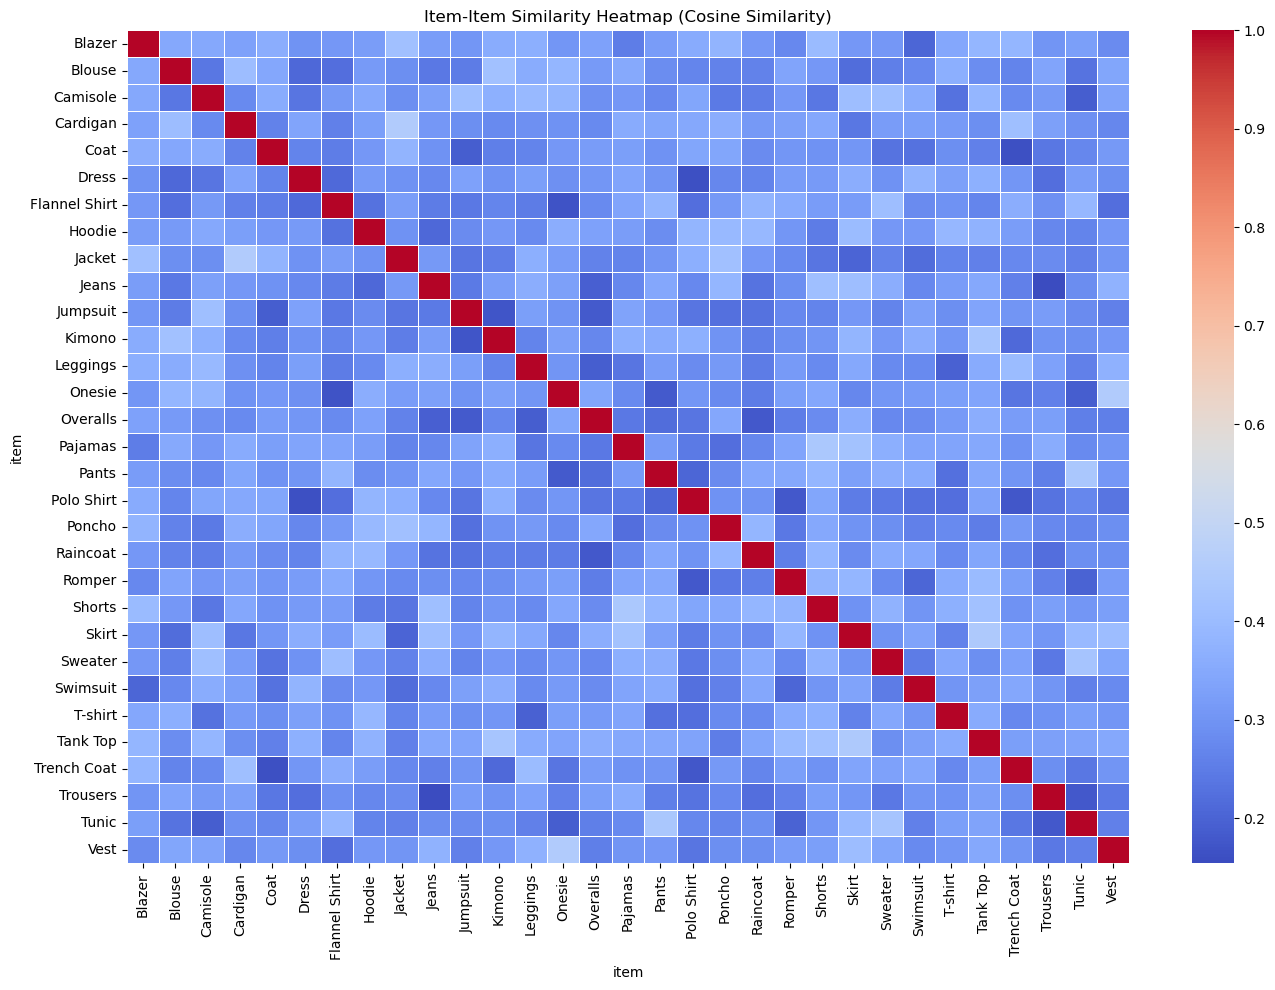

'item-item-heatmap.png'

<Figure size 640x480 with 0 Axes>

In [5]:
# Plot a heatmap based on cosine similarity between items
plt.figure(figsize=(14, 10))
sns.heatmap(item_similarity_df, 
            cmap="coolwarm", 
            annot=False, 
            fmt=".2f", 
            linewidths=0.5, 
            xticklabels=item_similarity_df.columns, 
            yticklabels=item_similarity_df.index)

plt.title("Item-Item Similarity Heatmap (Cosine Similarity)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Save as image
heatmap_path = "item-item-heatmap.png"
plt.savefig(heatmap_path, bbox_inches='tight')

heatmap_path

In [6]:
def find_similar_items(item_name, top_n=5):
    # Normalize casing
    item_name_lower = item_name.lower()
    all_items = [col for col in item_similarity_df.columns]
    matched_items = [item for item in all_items if item.lower() == item_name_lower]
    
    if not matched_items:
        print(f"Item '{item_name}' not found. Please check the spelling or try another item.")
        return
    
    matched_item = matched_items[0]  
    
    similar_items = item_similarity_df[matched_item].drop(matched_item).sort_values(ascending=False).head(top_n)
    print(f"\nTop {top_n} items similar to '{matched_item}':")
    for similar_item, score in similar_items.items():
        print(f"{similar_item}: similarity score = {score:.2f}")

# Prompt once per run
user_input = input("Enter an item name to find similar products: ").strip()
n = int(input("How many similar items do you want to see? (default 5): ") or 5)

find_similar_items(user_input, top_n=n)





Top 3 items similar to 'Hoodie':
Skirt: similarity score = 0.40
Poncho: similarity score = 0.39
Raincoat: similarity score = 0.39


In [7]:
import pandas as pd

# Load the data
df = pd.read_csv('retail_sales.csv')

# Count total number of sales
total_sales = len(df)

# Count unique items
unique_items = df['item'].nunique()

# Count items by category
item_counts = df['item'].value_counts()

# Print results
print(f"\nTotal number of sales: {total_sales}")
print(f"Number of unique items: {unique_items}")
print("\nItems sold (sorted by quantity):")
print(item_counts) 


Total number of sales: 3400
Number of unique items: 50

Items sold (sorted by quantity):
item
Belt             90
Skirt            88
Shorts           87
Pants            86
Tank Top         82
T-shirt          82
Pajamas          81
Camisole         76
Loafers          76
Hoodie           75
Poncho           73
Socks            73
Kimono           73
Blouse           73
Wallet           73
Handbag          72
Cardigan         72
Vest             71
Sneakers         71
Onesie           71
Backpack         71
Blazer           71
Umbrella         70
Raincoat         69
Trench Coat      68
Hat              68
Sunglasses       67
Coat             67
Scarf            66
Swimsuit         66
Boots            65
Jacket           64
Romper           64
Flannel Shirt    63
Leggings         62
Sweater          62
Overalls         61
Tunic            61
Polo Shirt       59
Gloves           59
Jeans            58
Slippers         58
Trousers         58
Jumpsuit         57
Dress            57
Tie  

In [8]:
from ipywidgets import widgets, interactive
import plotly.graph_objects as go
import pandas as pd

# Group by item and month: sum of sales and count of sold entries
ts_sales_full = retail_df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum'),
    Units_Sold=('item', 'count')
).reset_index()
ts_sales_full['month'] = ts_sales_full['month'].dt.to_timestamp()

# Dropdown options
items_list = sorted(ts_sales_full['item'].unique())

# Plot function
def plot_multiple_items(selected_items):
    fig = go.Figure()
    
    for item in selected_items:
        item_data = ts_sales_full[ts_sales_full['item'] == item]
        fig.add_trace(go.Scatter(
            x=item_data['month'],
            y=item_data['Total_Sales'],
            mode='lines+markers',
            name=item,
            customdata=item_data[['Units_Sold']],
            hovertemplate=(
                f"<b>{item}</b><br>" +
                "Month: %{x|%b %Y}<br>" +
                "Sales: $%{y:.2f}<br>" +
                "Units Sold: %{customdata[0]}<extra></extra>"
            ),
            line=dict(width=2)
        ))
    
    fig.update_layout(
        title="Seasonal Sales Trends (Multiple Items)",
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)",
        hovermode='closest',  # <- tooltips only on data points
        template='plotly_white',
        height=600
    )
    fig.show()

# Dropdown-style multi-select using SelectMultiple
multi_dropdown = widgets.SelectMultiple(
    options=items_list,
    description='Choose Items:',
    style={'description_width': 'initial'},
    layout={'width': '50%', 'height': '150px'}
)

interactive(plot_multiple_items, selected_items=multi_dropdown)

# fig.write_html("item_trend.html")

interactive(children=(SelectMultiple(description='Choose Items:', layout=Layout(height='150px', width='50%'), …

In [9]:
import warnings
import plotly.graph_objects as go
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from ipywidgets import interact, Dropdown
warnings.filterwarnings("ignore")


# Prepare the monthly total sales per item
ts_sales = df.copy()
ts_sales['date'] = pd.to_datetime(ts_sales['date'])
ts_sales['month'] = ts_sales['date'].dt.to_period('M').dt.to_timestamp()
ts_sales = ts_sales.dropna(subset=['amount_usd'])

monthly_sales = ts_sales.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# Define forecasting function
def forecast_item(item_name, periods=6):
    item_data = monthly_sales[monthly_sales['item'] == item_name].copy()
    item_data = item_data.set_index('month').resample('M').sum().fillna(0)
    
    # Train ARIMA model
    model = ARIMA(item_data['Total_Sales'], order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=periods)
    forecast_index = pd.date_range(item_data.index[-1] + pd.DateOffset(months=1), periods=periods, freq='M')
    
    # Plot original + forecast
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=item_data.index, y=item_data['Total_Sales'],
                             mode='lines+markers', name='Historical Sales'))
    fig.add_trace(go.Scatter(x=forecast_index, y=forecast.predicted_mean,
                             mode='lines+markers', name='Forecasted Sales'))
    
    fig.update_layout(
        title=f"Sales Forecast for {item_name}",
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)",
        template="plotly_white"
    )
    fig.show()

# Interactive widget for selecting item
item_dropdown = Dropdown(
    options=sorted(monthly_sales['item'].unique()),
    description='Select Item:',
    layout={'width': '50%'}
)

interact(forecast_item, item_name=item_dropdown)
# fig.write_html("item_forecast.html")

interactive(children=(Dropdown(description='Select Item:', layout=Layout(width='50%'), options=('Backpack', 'B…

<function __main__.forecast_item(item_name, periods=6)>

In [ ]:
# Detect peak sales months for each item
# This can help decide when to market each product


# Step 2: Find peak sales month(s) for each item
peak_months = monthly_sales.loc[
    monthly_sales.groupby('item')['Total_Sales'].idxmax()
][['item', 'month', 'Total_Sales']].sort_values(by='month')

# Redefine monthly_sales since the variable was lost in prior cell
df = pd.read_csv('retail_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=['amount_usd'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

monthly_sales = df.groupby(['item', 'month']).agg(
    Total_Sales=('amount_usd', 'sum')
).reset_index()

# Find peak sales month for each item
peak_months = monthly_sales.loc[
    monthly_sales.groupby('item')['Total_Sales'].idxmax()
][['item', 'month', 'Total_Sales']].sort_values(by='month')

print(peak_months)

# The single month when each item hit its highest total sales.

# Ordered by month to see which items peak early in the year vs. later.
# ➤ “When should I market this product?”
# ➤ “Which items peak in summer vs. winter?”


              item      month  Total_Sales
24          Blazer 2022-10-01       5246.0
179         Hoodie 2022-10-01       3255.0
586         Wallet 2022-11-01       3412.0
538       Trousers 2022-11-01       2696.0
60          Bowtie 2022-11-01       4797.0
360        Sandals 2022-11-01        910.0
348         Romper 2022-11-01       4946.0
312     Polo Shirt 2022-11-01        819.0
275       Overalls 2022-11-01        787.0
469        Sweater 2022-12-01       5405.0
445        Sun Hat 2022-12-01        672.0
264         Onesie 2022-12-01       3662.0
288        Pajamas 2022-12-01       4211.0
133     Flip-Flops 2022-12-01       5375.0
74        Camisole 2023-01-01        775.0
159        Handbag 2023-02-01       4878.0
517            Tie 2023-02-01        825.0
483       Swimsuit 2023-02-01       3640.0
435          Socks 2023-02-01       3184.0
576           Vest 2023-02-01       1060.0
4         Backpack 2023-02-01        954.0
124  Flannel Shirt 2023-03-01       1196.0
507       T

In [ ]:
# Calculate co-purchase frequency and combine with item similarity (cosine-based)

# Step 1: Filter for clothing items only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]

clothing_df = df[df['item'].isin(clothing_items)].copy()

# Step 2: Create binary matrix of co-purchases (1 if customer bought the item)
basket = clothing_df.groupby(['customerID', 'item']).size().unstack(fill_value=0)
basket[basket > 0] = 1  # Convert to binary

# Step 3: Compute co-purchase frequency (item-item)
co_purchase = basket.T.dot(basket)
co_purchase = co_purchase.fillna(0)

# Step 4: Normalize cosine similarity (reuse logic)
from sklearn.metrics.pairwise import cosine_similarity

user_item_matrix = clothing_df.pivot_table(index='customerID', columns='item', values='review', aggfunc='mean')
user_item_filled = user_item_matrix.fillna(0)
item_similarity_matrix = cosine_similarity(user_item_filled.T)
item_similarity_df = pd.DataFrame(item_similarity_matrix, index=user_item_filled.columns, columns=user_item_filled.columns)

# Step 5: Combine both into a new DataFrame to recommend bundling
bundle_recommendations = []

for item in co_purchase.columns:
    combined_score = (co_purchase[item] / co_purchase[item].max()) * 0.5 + \
                     (item_similarity_df[item] / item_similarity_df[item].max()) * 0.5
    top_bundle = combined_score.drop(item).sort_values(ascending=False).head(3)
    for related_item, score in top_bundle.items():
        bundle_recommendations.append({
            'Item': item,
            'Recommended_Bundle': related_item,
            'Bundle_Score': round(score, 3)
        })

bundle_df = pd.DataFrame(bundle_recommendations)
bundle_df

@interact(item=Dropdown(options=basket.columns, description="Item"))
def recommend_bundles(item):
    top_related = bundle_df[bundle_df['Item'] == item].sort_values(by='Bundle_Score', ascending=False)
    display(top_related[['Recommended_Bundle', 'Bundle_Score']])


interactive(children=(Dropdown(description='Item', options=('Blazer', 'Blouse', 'Camisole', 'Cardigan', 'Coat'…

In [12]:
# Segment sales by payment method and review score

# 1. Clean data (ensure 'review' is filled where necessary)
df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))

# 2. Bin review scores into categories
bins = [0, 2, 3.5, 5]
labels = ['Low (<=2)', 'Medium (2-3.5)', 'High (>3.5)']
df['Review_Level'] = pd.cut(df['review'], bins=bins, labels=labels, include_lowest=True)

# 3. Group by item, payment, and review level
segmented_sales = df.groupby(['item', 'payment', 'Review_Level']).agg(
    Total_Sales=('amount_usd', 'sum'),
    Units_Sold=('item', 'count'),
    Avg_Review=('review', 'mean')
).reset_index().sort_values(['item', 'Total_Sales'], ascending=[True, False])

print(segmented_sales)

         item      payment    Review_Level  Total_Sales  Units_Sold  \
1    Backpack         Cash  Medium (2-3.5)       1347.0          12   
4    Backpack  Credit Card  Medium (2-3.5)       1318.0          11   
2    Backpack         Cash     High (>3.5)       1087.0           9   
3    Backpack  Credit Card       Low (<=2)        970.0           8   
5    Backpack  Credit Card     High (>3.5)        741.0           9   
..        ...          ...             ...          ...         ...   
298    Wallet  Credit Card  Medium (2-3.5)       1684.0          17   
299    Wallet  Credit Card     High (>3.5)       1341.0          10   
295    Wallet         Cash  Medium (2-3.5)       1115.0          13   
297    Wallet  Credit Card       Low (<=2)        975.0           8   
294    Wallet         Cash       Low (<=2)        210.0           2   

     Avg_Review  
1      2.878045  
4      2.815734  
2      4.566667  
3      1.600000  
5      4.400000  
..          ...  
298    2.911134  
299

In [ ]:
@interact(item=Dropdown(options=df['item'].unique(), description="Item"))
def segment_view(item):
    seg_view = segmented_sales[segmented_sales['item'] == item]
    display(seg_view[['payment', 'Review_Level', 'Total_Sales', 'Units_Sold', 'Avg_Review']])


interactive(children=(Dropdown(description='Item', options=('Handbag', 'Tunic', 'Tank Top', 'Leggings', 'Walle…

In [14]:
import pandas as pd
from ipywidgets import interact, Dropdown
from IPython.display import display

# Load and preprocess (if not already done)
df = pd.read_csv("retail_sales.csv")
df['date'] = pd.to_datetime(df['date'])
df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
df['amount_usd'] = df.groupby('item')['amount_usd'].transform(lambda x: x.fillna(x.mean()))

# Filter for clothing items only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
df = df[df['item'].isin(clothing_items)].copy()

# Interactive function
@interact(customer_id=Dropdown(options=sorted(df['customerID'].unique()), description='Customer ID:'))
def show_customer_history(customer_id):
    customer_data = df[df['customerID'] == customer_id].sort_values(by='date')
    display(customer_data[['date', 'item', 'amount_usd', 'review', 'payment']].reset_index(drop=True))


interactive(children=(Dropdown(description='Customer ID:', options=(3957, 3958, 3959, 3960, 3961, 3962, 3963, …

In [15]:
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact, Dropdown

# Load & preprocess (skip if already done)
df = pd.read_csv("retail_sales.csv")
df['date'] = pd.to_datetime(df['date'])
df['review'] = df.groupby('item')['review'].transform(lambda x: x.fillna(x.mean()))
df['amount_usd'] = df.groupby('item')['amount_usd'].transform(lambda x: x.fillna(x.mean()))

# Filter to clothing only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
df = df[df['item'].isin(clothing_items)].copy()

# Interactive plot function
@interact(customer_id=Dropdown(options=sorted(df['customerID'].unique()), description='Customer ID:'))
def plot_customer_reviews(customer_id):
    cust_data = df[df['customerID'] == customer_id].sort_values('date')
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=cust_data['date'],
        y=cust_data['review'],
        mode='lines+markers',
        name=f"Customer {customer_id}",
        text=[f"Item: {item}<br>Amount: ${amt:.2f}" 
              for item, amt in zip(cust_data['item'], cust_data['amount_usd'])],
        hoverinfo='text+x+y',
        line=dict(color='royalblue', width=2)
    ))
    
    fig.update_layout(
        title=f"Review Ratings Over Time for Customer {customer_id}",
        xaxis_title='Purchase Date',
        yaxis_title='Review Score',
        yaxis=dict(range=[0, 5.5]),
        template='plotly_white',
        height=400
    )
    
    fig.show()


interactive(children=(Dropdown(description='Customer ID:', options=(3957, 3958, 3959, 3960, 3961, 3962, 3963, …

In [ ]:
# Redefine and clean base dataset
df = pd.read_csv('retail_sales.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.dropna(subset=['amount_usd'])
df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()

# Filter to clothing items only
clothing_items = [
    'Tunic', 'Tank Top', 'Leggings', 'Onesie', 'Jacket', 'Trousers', 'Jeans',
    'Pajamas', 'Trench Coat', 'Poncho', 'Romper', 'T-shirt', 'Shorts',
    'Blazer', 'Hoodie', 'Sweater', 'Blouse', 'Swimsuit', 'Kimono', 'Cardigan',
    'Dress', 'Camisole', 'Flannel Shirt', 'Polo Shirt', 'Overalls', 'Coat',
    'Vest', 'Jumpsuit', 'Raincoat', 'Skirt', 'Pants'
]
df = df[df['item'].isin(clothing_items)]

# Monthly sales aggregation
monthly_sales = df.groupby(['item', 'month']).agg(Total_Sales=('amount_usd', 'sum')).reset_index()

# Calculate first and peak month per item
first_months = monthly_sales.groupby('item')['month'].min().reset_index(name='First_Month')
peak_months = monthly_sales.loc[monthly_sales.groupby('item')['Total_Sales'].idxmax()][['item', 'month']].rename(columns={'month': 'Peak_Month'})

# Merge and compute lead time
timing_df = pd.merge(first_months, peak_months, on='item')
timing_df['Lead_Time_Months'] = (
    timing_df['Peak_Month'].dt.to_period('M') - timing_df['First_Month'].dt.to_period('M')
).apply(lambda x: x.n)

print(timing_df)

# First_Month: When the item first appeared in the dataset

# Peak_Month: When the item had its highest sales

# Lead_Time_Months: How many months it took to reach peak sales

# ➤ “How long after launch does this product usually take to become popular?”
# ➤ “How early should I introduce it before expecting strong sales?”

             item First_Month Peak_Month  Lead_Time_Months
0          Blazer  2022-10-01 2022-10-01                 0
1          Blouse  2022-10-01 2023-03-01                 5
2        Camisole  2022-10-01 2023-01-01                 3
3        Cardigan  2022-10-01 2023-04-01                 6
4            Coat  2022-10-01 2023-06-01                 8
5           Dress  2022-10-01 2023-04-01                 6
6   Flannel Shirt  2022-10-01 2023-03-01                 5
7          Hoodie  2022-10-01 2022-10-01                 0
8          Jacket  2022-10-01 2023-07-01                 9
9           Jeans  2022-10-01 2023-05-01                 7
10       Jumpsuit  2022-10-01 2023-06-01                 8
11         Kimono  2022-10-01 2023-05-01                 7
12       Leggings  2022-10-01 2023-03-01                 5
13         Onesie  2022-10-01 2022-12-01                 2
14       Overalls  2022-10-01 2022-11-01                 1
15        Pajamas  2022-10-01 2022-12-01                